# Pytorch

In [1]:
import os
import numpy as np
from PIL import Image


import torch
from torch import nn

from torchvision.models.segmentation import fcn_resnet50
from torchvision import transforms

import onnx
import onnxruntime as ort


In [2]:
img = Image.open("../CelebAMask-HQ/CelebA-HQ-img/0.jpg")

In [3]:
transform_img = transforms.Compose([transforms.Resize((512,512)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [4]:
imgs = transform_img(img)
c,h,w = imgs.shape
imgs = imgs.reshape(1,c,h,w)

### Download the model from [link](https://drive.google.com/file/d/1OrhIEVdYOd3TvOzao3a4Pz6AgBNlbnQD/view?usp=sharing)

In [5]:
checkpoint = torch.load("./models/pth/checkpoint-1.pth.tar")

In [6]:
model = fcn_resnet50(pretrained = False)

In [7]:
classifier = nn.Sequential(
        nn.Conv2d(2048, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
    nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.ReLU(),
    nn.Dropout(p=0.1, inplace=False),
    nn.Conv2d(512, 19, kernel_size=(1, 1), stride=(1, 1)))

model.classifier = classifier

In [8]:
del checkpoint["model"]["aux_classifier.0.weight"]
del checkpoint["model"]["aux_classifier.1.weight"]
del checkpoint["model"]["aux_classifier.1.bias"]
del checkpoint["model"]["aux_classifier.1.running_mean"]
del checkpoint["model"]["aux_classifier.1.running_var"]
del checkpoint["model"]["aux_classifier.1.num_batches_tracked"]
del checkpoint["model"]["aux_classifier.4.weight"]
del checkpoint["model"]["aux_classifier.4.bias"]

In [9]:
model = model.cuda()

In [10]:
model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [11]:
model = model.requires_grad_(False)

In [12]:
output = model.forward(imgs.cuda())["out"]

In [13]:
output = output.permute(0,2,3,1).squeeze().argmax(axis = 2).cpu().numpy()

## For all labels

In [14]:
label_list = ['skin', 'nose', 'eye_g', 'l_eye', 'r_eye', 'l_brow', 'r_brow', 'l_ear', 'r_ear', 'mouth', 'u_lip', 'l_lip', 'hair', 'hat', 'ear_r', 'neck_l', 'neck', 'cloth']

colors = np.array([[  3, 120, 213],
       [180,   5, 211],
       [247,  89, 109],
       [ 23,  25,  45],
       [ 93,   6, 253],
       [249,  93, 234],
       [ 58,  20, 155],
       [  7, 216, 167],
       [ 65, 237,  65],
       [245, 142, 148],
       [144,  11,  81],
       [ 46, 195, 165],
       [197,  51,   0],
       [189, 159,  20],
       [181, 208, 158],
       [233,  87,  54],
       [ 35,  74,  36],
       [198,  40, 139],
       [ 97,  77, 189]])

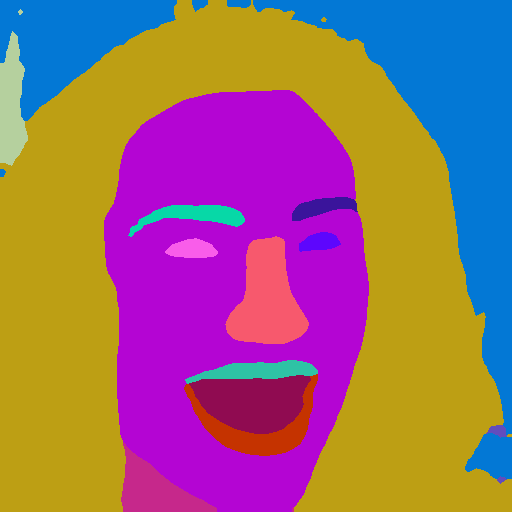

In [15]:
im_base = np.zeros((512, 512, 3))
for x in range(len(label_list)+1):
    im_base[output == x] = colors[x]

result = Image.fromarray((im_base).astype(np.uint8))
result

# ONNX-RUNTIME

In [18]:
img = Image.open("../CelebAMask-HQ/CelebA-HQ-img/0.jpg")

In [19]:
transform_img = transforms.Compose([transforms.Resize((512,512)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [20]:
imgs = transform_img(img)
c,h,w = imgs.shape
imgs = imgs.reshape(1,c,h,w)

### Download the model from [link](https://drive.google.com/file/d/17m_jhdMGAjm8ieL5Gh61f68zTyD-OYQF/view?usp=sharing)

In [21]:
model = onnx.load("./models/onnx/checkpoint-onnx-1.onnx")

In [23]:
ort_session = ort.InferenceSession("./models/onnx/checkpoint-onnx-1.onnx")

outputs = ort_session.run(["output"], {'input': imgs.numpy().astype(np.float32)})

outputs[0] = outputs[0]#.squeeze() * 255

In [24]:
output = outputs[0].transpose(0,2,3,1).squeeze().argmax(axis = 2)

In [25]:
output.shape

(512, 512)

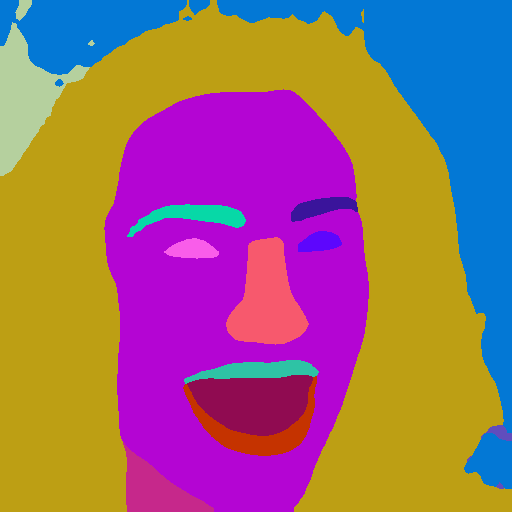

In [26]:
im_base = np.zeros((512, 512, 3))
for x in range(19):
    im_base[output == x] = colors[x]

result = Image.fromarray((im_base).astype(np.uint8))
result